In [ ]:
DBFILE="allblocks-istanbul-1s-gas20mio_run2.db"
NAME_PREFIX="istanbul-1s-gas20mio_run2"

# analyze `....db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

In this specific case the "Quorum" client of the EEA, and the `IBFT` variant, with varying gasLimit.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://gitlab.com/electronDLT/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>10000 TPS shot at the Quorum-Istanbul node</a>
# my own experiment: 
## 10000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-istanbul-1s-gas20mio_run2.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 87 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 86)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 87


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 86.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 104460
txcount_max 760
txcount_av 229.89655172413794
txcount_sum 20001
blocks_nonempty_count 30
av tx per nonempty blocks =  666.7


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:10]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,0,691,0,20000000,0
1,1,1534171625,1100,0,20004881,0
2,2,1534171635,1100,0,20009764,0
3,3,1534171636,1100,0,20014648,0
4,4,1534171637,1100,0,20019533,0
5,5,1534171638,1100,0,20024419,0
6,6,1534171639,1100,0,20029306,0
7,7,1534171640,1100,0,20034194,0
8,8,1534171649,1100,0,20039084,0
9,9,1534171650,1100,0,20043975,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
71,71,1534171778,104460,20285160,20349550,760,1.0,760.000000,759.333333,316.333333,237.093750,20285160.00,2.026737e+07,8.443253e+06,2.034955e+07,2.034459e+07,8.474842e+06
69,69,1534171776,104320,20258469,20339621,759,1.0,759.000000,227.700000,210.777778,194.435897,20258469.00,6.077541e+06,5.625870e+06,2.033962e+07,6.100398e+06,5.647138e+06
70,70,1534171777,104325,20258469,20344585,759,1.0,759.000000,325.285714,253.000000,210.694444,20258469.00,8.682201e+06,6.752823e+06,2.034458e+07,8.716981e+06,6.778220e+06
46,46,1534171687,72769,14066157,20225778,527,1.0,527.000000,297.333333,178.600000,89.300000,14066157.00,7.941124e+06,4.783709e+06,2.022578e+07,2.022084e+07,2.021591e+07
72,72,1534171779,49379,9475305,20354517,355,1.0,355.000000,624.666667,376.888889,247.724138,9475305.00,1.667298e+07,1.005954e+07,2.035452e+07,2.034955e+07,1.130255e+07
45,45,1534171686,38569,7393407,20220843,277,1.0,277.000000,121.666667,73.200000,36.600000,7393407.00,3.252405e+06,1.970478e+06,2.022084e+07,2.021591e+07,2.021098e+07
52,52,1534171708,103913,20178396,20255414,756,3.0,252.000000,206.181818,208.555556,209.840000,6726132.00,5.503199e+06,5.566556e+06,6.751805e+06,5.522856e+06,5.623759e+06
48,48,1534171693,100504,19511121,20235652,731,3.0,243.666667,265.428571,247.000000,158.857143,6503707.00,7.084554e+06,6.594344e+06,6.745217e+06,8.670306e+06,1.123654e+07
47,47,1534171690,82703,16014600,20230714,600,3.0,200.000000,280.800000,213.142857,124.416667,5338200.00,7.494833e+06,5.691139e+06,6.743571e+06,1.213547e+07,1.444346e+07
67,67,1534171770,104326,20258469,20329696,759,4.0,189.750000,189.666667,189.600000,184.853659,5064617.25,5.062393e+06,5.060614e+06,5.082424e+06,5.081184e+06,5.079944e+06


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
78,78,1534171785,1100,0,20384343,0,1.0,0.0,0.000000,0.000000,263.300000,0.0,0.000000e+00,0.000000e+00,20384343.00,2.037937e+07,2.037440e+07
72,72,1534171779,49379,9475305,20354517,355,1.0,355.0,624.666667,376.888889,247.724138,9475305.0,1.667298e+07,1.005954e+07,20354517.00,2.034955e+07,1.130255e+07
73,73,1534171780,1100,0,20359485,0,1.0,0.0,371.666667,526.600000,247.153846,0.0,9.920155e+06,1.405548e+07,20359485.00,2.035452e+07,2.034955e+07
74,74,1534171781,1100,0,20364454,0,1.0,0.0,118.333333,374.800000,246.434783,0.0,3.158435e+06,1.000379e+07,20364454.00,2.035949e+07,2.035452e+07
75,75,1534171782,1100,0,20369424,0,1.0,0.0,0.000000,223.000000,245.500000,0.0,0.000000e+00,5.952093e+06,20369424.00,2.036445e+07,2.035949e+07
76,76,1534171783,1100,0,20374396,0,1.0,0.0,0.000000,71.000000,244.176471,0.0,0.000000e+00,1.895061e+06,20374396.00,2.036942e+07,2.036446e+07
77,77,1534171784,1100,0,20379369,0,1.0,0.0,0.000000,0.000000,242.285714,0.0,0.000000e+00,0.000000e+00,20379369.00,2.037440e+07,2.036943e+07
71,71,1534171778,104460,20285160,20349550,760,1.0,760.0,759.333333,316.333333,237.093750,20285160.0,2.026737e+07,8.443253e+06,20349550.00,2.034459e+07,8.474842e+06
54,54,1534171716,103918,20178396,20265303,756,4.0,189.0,206.181818,198.947368,215.161290,5044599.0,5.503199e+06,5.310104e+06,5066325.75,5.525552e+06,5.330373e+06
53,53,1534171712,103908,20178396,20260358,756,4.0,189.0,206.181818,198.894737,214.357143,5044599.0,5.503199e+06,5.308699e+06,5065089.50,5.524204e+06,5.329072e+06


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>whole chain</a>


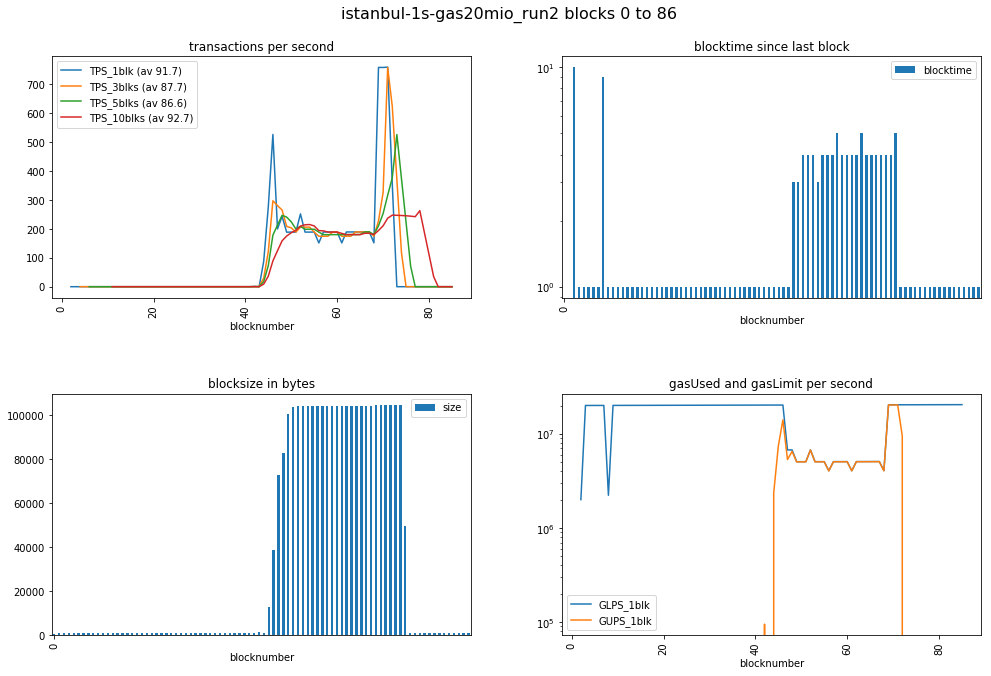

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='experiment1'>zoom in on one experiment</a>

# final experiment ...


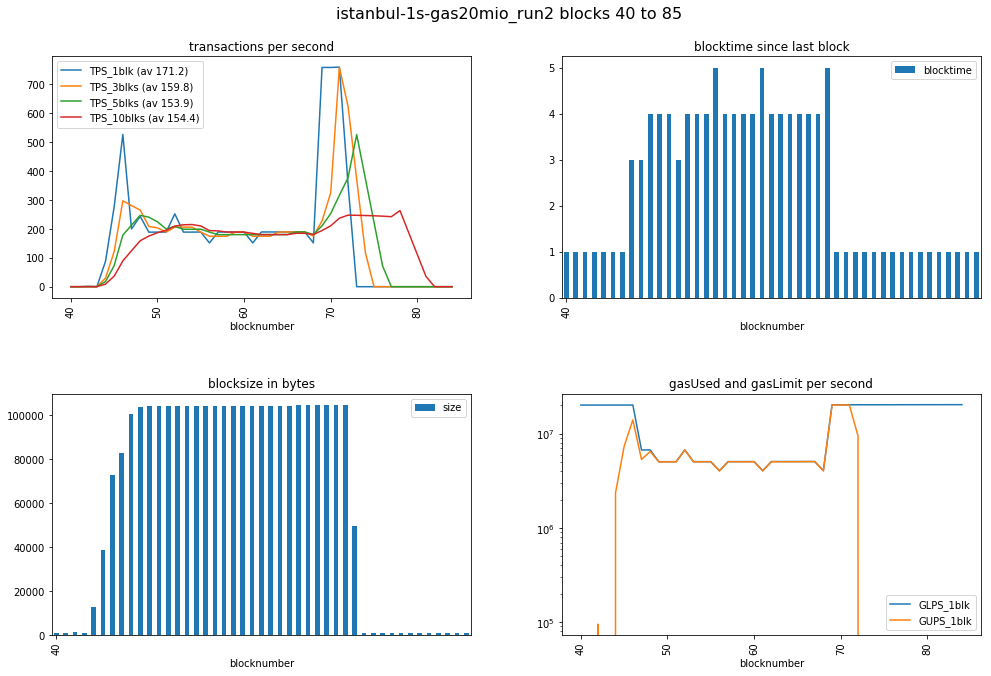

In [ ]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 40, 85, NAME_PREFIX, gas_logy=True, bt_logy=False)